# Neural Networks on MNIST data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import torch
from IPython.core.debugger import set_trace

In [24]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

---
## Data loading 

In [4]:
path = 'data/'

In [5]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [6]:
get_data(URL+FILENAME, path+FILENAME)

((x, y), (x_valid, y_valid), (x_test,y_test)) = load_mnist(path+FILENAME)

In [7]:
len(x), len(y), len(x_valid), len(y_valid), len(x_test),len(y_test)

(50000, 50000, 10000, 10000, 10000, 10000)

We have 50000 images in train. 10000 images in validation and test data. There are 10 classes

---
## Normalization

##### Normalization is better when feeding data to neural networks. RF is not affected by scale so not required. But neural networks are affected by scale otherwise NN has to learn the mean and std by itself.

In [8]:
mean = x.mean()

std = x.std()

x = (x -mean)/std

mean,std,x.mean(),x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

### Note on normalization:
* Train and validation should have same normalization
* For RGB image,normalization for each channel
* Structural: Normalization for each fetaure separately

##### Same normalization has to applied to validation/test data

In [9]:
x_valid = (x_valid-mean)/std

In [10]:
x_valid.mean(),x_valid.std()

(-0.0058509219, 0.99243325)

In [11]:
x_valid.shape

(10000, 784)

### Reshaping your tensors

In [12]:
x_valid.reshape(-1, 28,28).shape #-1 is entered as reshape will identify by itself what is that order based on input

(10000, 28, 28)

In [13]:
x_imgs = x_valid.reshape(-1,28,28) #store 10000 images as matrix of 28*28

In [14]:
def img_show(img,title = None):
    plt.imshow(img,cmap='gray')
    if title is not None: plt.title(title) 

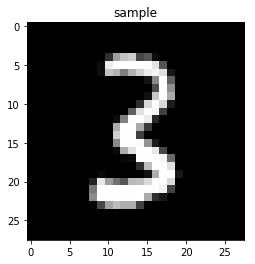

In [15]:
img_show(x_imgs[0],"sample") #this will pick the first image

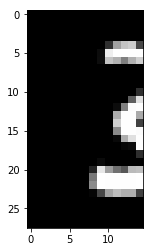

In [16]:
img_show(x_imgs[0,0:28,0:15]) #indexing into the image and grabbing a portion of the image

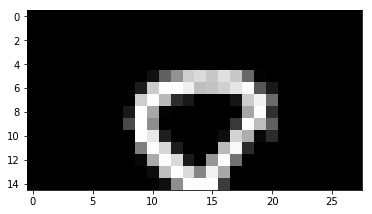

In [17]:
img_show(x_imgs[1,0:15,])

##### len will return the length of the 1st dimension

In [18]:
len(x_imgs) 

10000

In [19]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

## Neural Nets with Pytorch

In [31]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
import torch.nn as nn
import torch
from torch.autograd import Variable


In [40]:
d = torch.randn(2,3);d #creating a tensor of size 2*3


 0.3435 -1.8753  0.0314
-0.2613 -0.6217  1.3435
[torch.FloatTensor of size 2x3]

### Creating neural network, the easiest way

### Defining the network using pytorch completely

In [22]:
net1 = nn.Sequential(
nn.Linear(28*28,10,bias=True), #assuming input the network is number of images * 784, 
    #output of this layer will be number of images * 10
nn.LogSoftmax())

In [27]:
md = ImageClassifierData.from_arrays(path,(x,y),(x_valid,y_valid))
loss = nn.CrossEntropyLoss() #calculate cross entropy
metrics = [accuracy] #calculate accuracy based on predicted labels
opt = optim.Adam(net1.parameters()) #default learning rate = 1e-3

### Breaking it down

#### Looking at the linear layer

In [43]:
a = nn.Linear(2*2,2);a

Linear(in_features=4, out_features=2)

In [44]:
a.weight,a.bias #these are randomly initialized

(Parameter containing:
 -0.0653 -0.0126  0.3459  0.2476
 -0.2021  0.3311 -0.0455  0.3022
 [torch.FloatTensor of size 2x4], Parameter containing:
 1.00000e-02 *
  -3.8037
   1.6915
 [torch.FloatTensor of size 2])

In [45]:
b = torch.autograd.Variable(torch.randn(5,4));x #sample input

array([[-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       ..., 
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452],
       [-0.42452, -0.42452, -0.42452, ..., -0.42452, -0.42452, -0.42452]], dtype=float32)

In [46]:
a(b) #it applies the linear layer on the sample input defined

Variable containing:
 0.4217 -0.5243
-0.0145 -0.1121
-0.3915  0.4453
-0.1654  0.3737
-0.3140 -0.0277
[torch.FloatTensor of size 5x2]

#### Looking at the softmax function

In [48]:
m = nn.LogSoftmax()

In [49]:
a(b) #sample input: assume 5 images of 2*2 size flattened out

Variable containing:
 0.4217 -0.5243
-0.0145 -0.1121
-0.3915  0.4453
-0.1654  0.3737
-0.3140 -0.0277
[torch.FloatTensor of size 5x2]

In [51]:
o = m(a(b));o #applying logsoftmax to x

Variable containing:
-0.3281 -1.2741
-0.6455 -0.7432
-1.1966 -0.3598
-0.9986 -0.4595
-0.8465 -0.5602
[torch.FloatTensor of size 5x2]

In [52]:
c = torch.exp(o);c #visualize what happens before the log....each row is an image with probabilities for 2 classes

Variable containing:
 0.7203  0.2797
 0.5244  0.4756
 0.3022  0.6978
 0.3684  0.6316
 0.4289  0.5711
[torch.FloatTensor of size 5x2]

In [53]:
c.sum(dim = 1) #if we sum probabilities for each row it should comes out to be 1 as expected

Variable containing:
 1
 1
 1
 1
 1
[torch.FloatTensor of size 5]

#### Understanding how loss function works

In [56]:
o #output of the network: 5 images and 2 probabilities, one for each class

Variable containing:
-0.3281 -1.2741
-0.6455 -0.7432
-1.1966 -0.3598
-0.9986 -0.4595
-0.8465 -0.5602
[torch.FloatTensor of size 5x2]

In [57]:
target = torch.autograd.Variable(torch.LongTensor([1,0,0,1,1]));target #actual labels for the images

Variable containing:
 1
 0
 0
 1
 1
[torch.LongTensor of size 5]

In [81]:
loss(o,target)

Variable containing:
 0.8272
[torch.FloatTensor of size 1]

#### Understanding the parameters of the network

##### Parameters are special variables that need to be optimized

In [59]:
#print the weight and bias that is initialized for the network
for param in net1.parameters():
    print(param.data,param.size())


1.00000e-02 *
-2.3515  0.7402  2.3409  ...   1.9743  0.4335  1.1682
 1.3010 -2.2125  1.0557  ...  -1.6530 -0.8854 -1.5714
 1.8836  0.5618  2.2912  ...  -1.2920  1.8926 -2.0600
          ...             ⋱             ...          
-2.2435  1.7190 -2.3596  ...  -1.3464 -2.0486 -2.4651
-1.8301 -2.3354 -1.1920  ...   1.8446 -2.9820 -0.1622
-2.0340  3.4815  1.1783  ...  -2.1601  3.0085 -0.6187
[torch.FloatTensor of size 10x784]
 torch.Size([10, 784])

1.00000e-02 *
 -0.6637
  3.5713
  0.5087
 -2.2796
 -2.7554
  2.5491
 -1.4423
  1.1600
 -2.9389
 -3.2559
[torch.FloatTensor of size 10]
 torch.Size([10])


### Network training 

In [82]:
fit(net1,md,opt=opt,epochs=3,crit=loss, metrics = metrics) #accuracy is calculated on validation: the right most value

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.3269   0.28869  0.91909]                         
[ 1.       0.29029  0.27693  0.92158]                         
[ 2.       0.29616  0.27416  0.92297]                         



**Learning rate annealing: When the accuracy is not changing much...one step could be higher learning rate so decrease that**

In [68]:
set_lrs(opt,1e-4) #you can change the learning rate. I'm reducing it for now to 1e-4

In [69]:
fit(net1,md,opt=opt,epochs=3,crit=loss, metrics = metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.22552  0.25487  0.93123]                         
[ 1.       0.26174  0.25458  0.93033]                         
[ 2.       0.23447  0.25411  0.93173]                         



##### And we can see that it worked!!

### Prediction on validation and calculating the accuracy

In [70]:
preds_logp = predict(net1,md.val_dl)

In [71]:
preds_logp.shape

(10000, 10)

In [72]:
preds_logp #these are log probabilities for 10000 images and 10 classes

array([[-11.16182,  -5.08505,  -2.63484, ..., -18.82728,  -3.74848, -13.18584],
       [-14.73604, -11.44917,  -5.03179, ..., -12.527  ,  -0.02473,  -8.57314],
       [ -4.85929, -14.92674,  -3.44053, ...,  -8.91454,  -9.50627, -10.67652],
       ..., 
       [-11.32161, -11.63077, -13.99092, ..., -13.13085,  -4.95353,  -9.40182],
       [ -5.52254, -12.54687,  -5.89197, ...,  -7.79232,  -9.55045,  -7.85595],
       [ -2.58306, -14.55401,  -6.24447, ...,  -9.15672,  -0.18943,  -4.00708]], dtype=float32)

In [73]:
preds = preds_logp.argmax(axis=1) #converting them to labels

In [74]:
preds.shape,preds #class prediction for each image

((10000,), array([3, 8, 6, ..., 5, 6, 8]))

In [75]:
np.mean(preds == md.val_y) # accuracy calculation

0.93140000000000001

---

### Building it from scratch with minimum use of pytorch inbuilt functions

### Defining your network

##### We are defining layers by ourselves instead of using nn.Sequential

In [40]:
def get_params(*dims): return nn.Parameter(torch.randn(dims)/dims[0]) #for numerical stability otherwise weights will explode or die out
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])
class custom_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = get_params(28*28,10) #creating weight matrix
        self.b = get_params(10) #creating bias matrix
    def forward(self,x):
#         set_trace()
        x = x.view(x.size(0),-1) #flattens the input matrix
        x = x@self.w + self.b #applying the linear layer  
        x = torch.log(softmax(x)) #applying logsoftmax
        return x

net2 = custom_net()
md = ImageClassifierData.from_arrays(path,(x,y),(x_valid,y_valid),bs=64)
opt = optim.Adam(net2.parameters(),lr=1e-3)
loss = nn.CrossEntropyLoss() #calculate cross entropy
metrics = [accuracy] #calculate accuracy based on predicted labels

In [41]:
net2.b.size(),net2.w.size()

(torch.Size([10]), torch.Size([784, 10]))

### Training your network

In [42]:
fit(data=md,model=net2,crit=loss,epochs=3,metrics=metrics,opt=opt)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


 13%|█▎        | 105/782 [00:02<00:13, 50.91it/s, loss=0.58] 


 28%|██▊       | 217/782 [00:02<00:07, 78.50it/s, loss=0.416]


 43%|████▎     | 340/782 [00:03<00:04, 92.26it/s, loss=0.366]


 59%|█████▊    | 458/782 [00:04<00:03, 101.78it/s, loss=0.343]


 74%|███████▍  | 579/782 [00:05<00:01, 108.67it/s, loss=0.326]


 88%|████████▊ | 692/782 [00:06<00:00, 110.46it/s, loss=0.332]


100%|█████████▉| 780/782 [00:06<00:00, 114.27it/s, loss=0.327]
                                                              [ 0.       0.32726  0.27743  0.92178]

  3%|▎         | 25/782 [00:00<00:29, 26.01it/s, loss=0.329]


 17%|█▋        | 135/782 [00:02<00:10, 59.72it/s, loss=0.294]


 33%|███▎      | 261/782 [00:03<00:06, 82.63it/s, loss=0.309]


 49%|████▉     | 384/782 [00:04<00:04, 95.70it/s, loss=0.303]


 64%|██████▍   | 502/782 [00:05<00:02, 100.36it/s, loss=0.313]


 78%|███████▊  | 607/782 [00:05<00:01, 102.64it/s, loss=0.303]


 93%|█████████▎| 726/782 [00:06<00:00, 109.16it/s, loss=0.289]


 99%|█████████▉| 773/782 [00:07<00:00, 109.20it/s, loss=0.292]
                                                              [ 1.       0.29168  0.26723  0.92406]

  8%|▊         | 62/782 [00:01<00:17, 42.34it/s, loss=0.283]


 21%|██        | 166/782 [00:02<00:09, 64.58it/s, loss=0.294]


 36%|███▋      | 285/782 [00:03<00:05, 83.45it/s, loss=0.278]


 53%|█████▎    | 411/782 [00:04<00:03, 96.53it/s, loss=0.281]


 67%|██████▋   | 523/782 [00:05<00:02, 101.45it/s, loss=0.3]  


 84%|████████▍ | 655/782 [00:05<00:01, 109.42it/s, loss=0.296]


 98%|█████████▊| 765/782 [00:06<00:00, 113.31it/s, loss=0.28] 


 98%|█████████▊| 765/782 [00:06<00:00, 112.67it/s, loss=0.276]
                                                              [ 2.       0.27639  0.26888  0.92446]



In [36]:
t = [o.numel() for o in net2.parameters()] #to get number of elements in each layer: weights and bias matrix
t, sum(t)

([7840, 10], 7850)

* When the module is called as function it's forward method is called by default
* Log-probabilities is used for numerical stability

### Predicting on a batch of validation image through the network

In [46]:
xmb,ymb = next(iter(md.val_dl)) #you get a batch of 64 images

In [47]:
vxmb = Variable(xmb) #creating it as variable

In [48]:
vxmb

Variable containing:
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.FloatTensor of size 64x784]

In [49]:
pred_mb = net2(vxmb).exp();pred_mb #actual probabilities

Variable containing:

Columns 0 to 5 
 9.3875e-06  1.2792e-02  1.0261e-01  8.4361e-01  7.5153e-06  1.1666e-02
 6.4374e-07  5.6053e-05  8.2611e-03  5.6000e-03  2.1408e-03  1.2562e-02
 1.4951e-02  1.5325e-06  4.7089e-02  6.5586e-04  3.4612e-03  9.7633e-02
 1.4964e-05  1.0335e-04  1.7931e-03  1.7249e-03  2.1531e-02  1.8038e-04
 1.1841e-05  3.0741e-06  1.9197e-02  1.7218e-05  4.8209e-06  7.8083e-04
 9.7253e-06  4.3496e-03  4.9574e-02  1.1499e-04  6.2149e-01  3.8700e-03
 8.5901e-04  1.6863e-07  3.4930e-09  1.9053e-06  4.4253e-03  9.5416e-01
 4.5317e-03  2.6657e-03  1.4041e-03  2.0116e-01  1.4752e-06  7.4536e-01
 2.2664e-05  1.9086e-02  9.4565e-03  2.4757e-02  1.6123e-03  9.6586e-02
 5.3691e-06  2.1842e-04  2.4741e-02  7.7841e-04  8.1795e-01  6.3273e-03
 1.8152e-04  4.4304e-07  1.6061e-03  5.2647e-04  1.8840e-02  9.0895e-01
 3.9575e-06  5.3614e-07  9.9685e-01  2.5053e-03  1.4291e-07  7.9478e-06
 5.1675e-06  6.8197e-07  2.5594e-02  9.7350e-01  1.0550e-07  3.3660e-05
 7.4232e-07  1.7247e-04  4

In [51]:
y_pred = pred_mb.max(1)[1]#pytorch version of argmax...it returns class and maximum probabilities for each image

In [54]:
np.mean(to_np(y_pred)==to_np(ymb)) #to_np converts it to numpy array

0.921875

---

### Deeper Neural Networks

In [61]:
#deeper nn
net3 = nn.Sequential(
nn.Linear(28*28,100),
nn.ReLU(),
nn.Linear(100,10),
nn.LogSoftmax()) #use cuda() for GPU

md = ImageClassifierData.from_arrays(path,(x,y),(x_valid,y_valid),bs=64)
opt = optim.Adam(net3.parameters(),lr=1e-3)
loss = nn.CrossEntropyLoss() #calculate cross entropy
metrics = [accuracy] #calculate accuracy based on predicted labels

In [62]:
fit(data=md,model=net3,crit=loss,epochs=3,metrics=metrics,opt=opt)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.17676  0.15067  0.9575 ]                         
[ 1.       0.11428  0.10769  0.96994]                         
[ 2.       0.09703  0.10955  0.96885]                          



#### We can see that deeper networks are working much better

---

### Breaking it further into elements

##### Understanding how optimizer works

In [184]:
net4 = custom_net()
md = ImageClassifierData.from_arrays(path,(x,y),(x_valid,y_valid),bs=64)
opt = optim.Adam(net4.parameters(),lr=1e-3) 

In [185]:
xt,yt = next(iter(md.trn_dl))

In [186]:
xt.shape

torch.Size([64, 784])

In [187]:
ypred = net4(Variable(xt))

In [188]:
ypred #prediction on a batch of training images

Variable containing:
-2.4122 -2.3239 -2.1660 -2.3716 -2.2559 -2.2115 -2.2541 -2.4378 -2.3973 -2.2357
-2.4309 -2.2679 -2.1524 -2.2891 -2.3402 -2.2283 -2.2805 -2.4465 -2.4172 -2.2171
-2.4454 -2.3016 -2.1167 -2.2679 -2.3150 -2.2387 -2.2751 -2.4547 -2.4124 -2.2480
-2.4379 -2.2842 -2.1132 -2.3323 -2.2790 -2.3010 -2.2859 -2.4232 -2.4013 -2.2127
-2.5253 -2.2697 -2.1422 -2.3682 -2.2287 -2.2323 -2.3011 -2.4150 -2.4031 -2.2011
-2.4342 -2.3050 -2.1719 -2.3366 -2.2851 -2.2187 -2.2569 -2.4152 -2.4110 -2.2285
-2.3966 -2.3650 -2.0882 -2.3057 -2.2015 -2.2303 -2.3369 -2.4858 -2.4448 -2.2382
-2.4488 -2.3126 -2.1484 -2.3090 -2.2161 -2.2371 -2.3134 -2.4039 -2.4243 -2.2544
-2.4399 -2.2451 -2.1395 -2.2934 -2.3277 -2.2513 -2.2747 -2.4515 -2.4399 -2.2134
-2.4468 -2.2865 -2.1557 -2.2376 -2.2655 -2.2778 -2.3251 -2.4341 -2.3965 -2.2395
-2.4432 -2.2404 -2.1335 -2.3020 -2.3632 -2.1963 -2.3433 -2.4091 -2.3887 -2.2515
-2.4985 -2.3215 -2.1328 -2.2884 -2.2703 -2.2231 -2.2572 -2.4755 -2.3834 -2.2333
-2.4310 -2.3259 -2.

In [189]:
w,b = net4.w,net4.b #storing weights and biases

In [190]:
w,b 

(Parameter containing:
 1.00000e-03 *
 -2.3094 -0.0706  0.2468  ...   0.2512 -1.5780  0.4417
  0.2034  0.9098  0.7063  ...   2.7903  2.4859  0.5419
 -0.6852  1.3061  0.7707  ...  -0.7222  0.2677 -0.2775
           ...             ⋱             ...          
  0.6679  1.6504 -0.6590  ...  -0.5789  2.3000 -2.1979
  0.8349 -0.5999  1.1897  ...  -0.5849  0.4705 -1.7466
  1.9556 -0.9380 -0.2632  ...  -1.4528 -1.0685  0.4858
 [torch.FloatTensor of size 784x10], Parameter containing:
 -0.1721
  0.0007
  0.1519
 -0.0198
 -0.0063
  0.0380
  0.0109
 -0.1354
 -0.0962
  0.0479
 [torch.FloatTensor of size 10])

In [191]:
l = loss(ypred,Variable(yt));l

Variable containing:
 2.2975
[torch.FloatTensor of size 1]

In [192]:
l.backward() #calculates gradients of loss with respect to every parameter

In [193]:
w.grad.data,b.grad.data

(
  0.0231  0.0032  0.0223  ...  -0.0106 -0.0253 -0.0123
  0.0231  0.0032  0.0223  ...  -0.0106 -0.0253 -0.0123
  0.0231  0.0032  0.0223  ...  -0.0106 -0.0253 -0.0123
           ...             ⋱             ...          
  0.0231  0.0032  0.0223  ...  -0.0106 -0.0253 -0.0123
  0.0231  0.0032  0.0223  ...  -0.0106 -0.0253 -0.0123
  0.0231  0.0032  0.0223  ...  -0.0106 -0.0253 -0.0123
 [torch.FloatTensor of size 784x10], 
 1.00000e-02 *
  -5.4514
  -0.7626
  -5.2566
  -5.7268
   3.8440
   2.9231
  -0.9428
   2.5082
   5.9694
   2.8956
 [torch.FloatTensor of size 10])

In [194]:
learning_rate = 1e-3

In [195]:
w.data - w.grad.data*learning_rate #this is what optimizer is doing behind the scenes


1.00000e-03 *
-2.3325 -0.0738  0.2245  ...   0.2618 -1.5526  0.4540
 0.1803  0.9065  0.6839  ...   2.8009  2.5113  0.5542
-0.7084  1.3029  0.7484  ...  -0.7115  0.2930 -0.2652
          ...             ⋱             ...          
 0.6448  1.6471 -0.6813  ...  -0.5682  2.3254 -2.1856
 0.8118 -0.6031  1.1673  ...  -0.5743  0.4959 -1.7343
 1.9325 -0.9412 -0.2855  ...  -1.4422 -1.0432  0.4981
[torch.FloatTensor of size 784x10]

In [196]:
opt.step()

In [197]:
w.data


1.00000e-03 *
-3.3094 -1.0705 -0.7531  ...   1.2512 -0.5780  1.4417
-0.7966 -0.0901 -0.2937  ...   3.7902  3.4859  1.5419
-1.6852  0.3062 -0.2293  ...   0.2778  1.2677  0.7225
          ...             ⋱             ...          
-0.3321  0.6505 -1.6589  ...   0.4211  3.3000 -1.1979
-0.1650 -1.5998  0.1897  ...   0.4151  1.4705 -0.7467
 0.9556 -1.9379 -1.2632  ...  -0.4528 -0.0685  1.4858
[torch.FloatTensor of size 784x10]

##### Replacing the optimizer and metrics

In [207]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [208]:
net5 = custom_net()
loss=nn.CrossEntropyLoss()
lr = 1e-3
w,b = net5.w,net5.b

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        xt, yt = next(dl)
        y_pred = net5(V(xt))
        l = loss(y_pred, Variable(yt))
        losses.append(l)

        

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
#         optimizer.step()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
#         optimizer.zero_grad()
        w.grad.data.zero_()
        b.grad.data.zero_() 
  

    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

0.924462579618


* Regularization: Weight decay or dropout
* Weight decay is similar to L1/L2 regularization but is not exactly the same
* Weight decay either during update or apply regularization in loss function
* But in adam optimizer these 2 are different concepts
* Sometimes weight decay can improve the loss surface 
* Weight decay finally result in relatively poor training loss

In [ ]:
w.grad.data

----

## Broadcasting

In [209]:
a = np.array([1,5,3])
b = np.array([3,4,4])

In [213]:
a.shape,b.shape

((3,), (3,))

#### element wise operation

In [211]:
a+b

array([4, 9, 7])

In [212]:
(a>b)

array([False,  True, False], dtype=bool)

In [ ]:
a*b #element wise multiplication

In [214]:
a = T([1,5,3])
b = T([3,4,4])

In [215]:
a,b

(
  1
  5
  3
 [torch.LongTensor of size 3], 
  3
  4
  4
 [torch.LongTensor of size 3])

In [216]:
a.size(),b.size()

(torch.Size([3]), torch.Size([3]))

In [217]:
a+b


 4
 9
 7
[torch.LongTensor of size 3]

In [218]:
a>b


 0
 1
 0
[torch.ByteTensor of size 3]

0 is being broadcasted here

In [219]:
a>0 #comparison of rank 1 tensor with rank 0 tensor


 1
 1
 1
[torch.ByteTensor of size 3]

In [264]:
x = np.array([[1,2,3],[3,4,5],[9,1,2]])

In [221]:
x

array([[1, 2, 3],
       [3, 4, 5],
       [9, 1, 2]])

In [222]:
x.shape

(3, 3)

In [223]:
2*x

array([[ 2,  4,  6],
       [ 6,  8, 10],
       [18,  2,  4]])

2 has been broadcasted here 

In [224]:
np.broadcast_to(2,x.shape)

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

In [225]:
y = np.array([10,20,30])

In [247]:
y.shape #rank 1 tensor is considered as a row vector

(3,)

In [228]:
x

array([[1, 2, 3],
       [3, 4, 5],
       [9, 1, 2]])

In [229]:
x+y

array([[11, 22, 33],
       [13, 24, 35],
       [19, 21, 32]])

In [230]:
np.broadcast_to(y,x.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [231]:
y[None]

array([[10, 20, 30]])

In [233]:
y[:,None]

array([[10],
       [20],
       [30]])

In [234]:
x+y[:,None]

array([[11, 12, 13],
       [23, 24, 25],
       [39, 31, 32]])

In [236]:
np.broadcast_to(y[:,None],x.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [239]:
y[:,None].shape

(3, 1)

In [237]:
y[None,:,None]

array([[[10],
        [20],
        [30]]])

In [242]:
x = np.array([[1,2,3],[3,4,5],[9,1,2],[1,3,4]])

In [243]:
x.shape

(4, 3)

In [245]:
np.broadcast_to(y, x.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [248]:
x@y

array([140, 260, 170, 190])

In [241]:
torch.randn(4,3) + torch.randn(3)


 0.3032 -0.0480  1.4770
 0.2023  0.3126  0.0615
 0.4882  0.5409  2.1542
-0.6509 -0.0625  1.9477
[torch.FloatTensor of size 4x3]

## Broadcasting rules

In [249]:
s = y[None]

In [250]:
t = y[:,None]

In [251]:
s,t

(array([[10, 20, 30]]), array([[10],
        [20],
        [30]]))

In [252]:
s.shape,t.shape

((1, 3), (3, 1))

In [255]:
s@t

array([[1400]])

In [256]:
s*t

array([[100, 200, 300],
       [200, 400, 600],
       [300, 600, 900]])

In [257]:
t@s

array([[100, 200, 300],
       [200, 400, 600],
       [300, 600, 900]])

In [261]:
s*y

array([[100, 400, 900]])

In [262]:
t*y

array([[100, 200, 300],
       [200, 400, 600],
       [300, 600, 900]])

In [265]:
x,y

(array([[1, 2, 3],
        [3, 4, 5],
        [9, 1, 2]]), array([10, 20, 30]))

In [266]:
x.shape

(3, 3)

In [267]:
y.shape

(3,)

In [268]:
(x@y).shape #empty dim is taken as 1

(3,)

In [269]:
(x@y)

array([140, 260, 170])

In [270]:
(T(x)@T(y)).size()

torch.Size([3])

In [271]:
(T(x)@T(y))


 140
 260
 170
[torch.LongTensor of size 3]

In [ ]:
(x*y).sum(axis =1) #same as matrix multiplication

----